In [177]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#reading images
hill1 = cv2.imread("1Hill.jpg")
hill2 = cv2.imread("2Hill.jpg")
hill3 = cv2.imread("3Hill.jpg")

#methods defined

def warpPerspectivePadded(src, dst_shape, M):
    """Performs an affine or Euclidean/rigid warp with padding.
    Parameters
    ----------
    src : image to be warped.
    dst : shape of static image i.e. dst.shape 
    M : `3x3` Homography matrix.
    Returns
    -------
    src_warped : padded and warped source image
    """
    
    # it is enough to find where the corners of the image go to find
    # the padding bounds; points in clockwise order from origin
    _, src_w = src.shape[:2]
    lin_pts = np.array([
        [0, src_w],
        [0, 0]])
    # transform points
    transf_lin_pts = M[:, :2].dot(lin_pts) + M[:, 2].reshape(3, 1)

    # find min and max points
    min_x = np.floor(np.min(transf_lin_pts)).astype(int)
    max_x = np.ceil(np.max(transf_lin_pts)).astype(int)

    # add translation to the transformation matrix to shift to positive values
    anchor_x = 0
    if min_x < 0:
        anchor_x = -min_x
    shifted_transf = M + [[0, 0, anchor_x], [0, 0, 0], [0, 0, 0]]

    # create padded destination image
    dst_h, dst_w,_ = dst_shape
    dst_pad_w = anchor_x + dst_w + max(max_x, dst_w) - dst_w
    src_warped =cv2.warpPerspective(src, shifted_transf, (dst_pad_w, dst_h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return src_warped

def pyramidBlending(A, B, depth=3):
  
    # generate Gaussian pyramid for A and B.
    GA = A.copy()
    GB = B.copy()
    gpA =[GA]
    gpB =[GB]
    for i in range(depth):
        GA = cv2.pyrDown(GA)
        gpA.append(GA)

        GB = cv2.pyrDown(GB)
        gpB.append(GB)

    # generate Laplacian Pyramid for A and B.
    lpA, lpB = [gpA[depth-1]], [gpB[depth-1]]
    for i in range(depth-1,0,-1):
        hA, wA, _ = gpA[i-1].shape
        # Make sure that the destination size matches that of gpA[i-1].
        L = cv2.subtract(gpA[i-1],cv2.pyrUp(gpA[i], dstsize=(wA, hA)))
        lpA.append(L)

        hB, wB, _ = gpB[i-1].shape
        # Make sure that the destination size matches that of gpB[i-1].
        L = cv2.subtract(gpB[i-1], cv2.pyrUp(gpB[i], dstsize=(wB, hB)))
        lpB.append(L)

    # Stack images together at each Laplacian Pyramid level.
    LS = []
    for la,lb in zip(lpA,lpB):
        ls = np.hstack((la, lb))
        LS.append(ls)

    # Blend and reconstruct the final image.
    rs = LS[0]
    for i in range(1,depth):
        h, w, _ = LS[i].shape
        rs = cv2.pyrUp(rs, dstsize=(w, h))
        rs = cv2.add(rs, LS[i])
    
    return rs.astype(np.uint8)

**CODING QUESTIONS**

In [169]:
#1) Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill.

# convert to RGB
hill1 = cv2.cvtColor(hill1, cv2.COLOR_BGR2RGB)
hill2 = cv2.cvtColor(hill2, cv2.COLOR_BGR2RGB)

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# Compute the keypoints/descriptors
keypoints_hill1,descriptors_hill1 = sift.detectAndCompute(hill1,None)
keypoints_hill2,descriptors_hill2 = sift.detectAndCompute(hill2,None)



Num keypoints: 2726


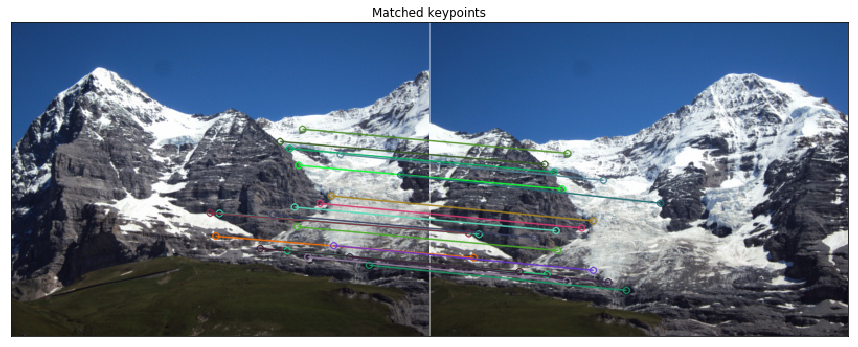

In [170]:
#2) Find matching keypoints in two images and display the 20 best pairs.

# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(descriptors_hill1,descriptors_hill2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 20 matches.
matched_disp = cv2.drawMatches(hill1, keypoints_hill1, hill2, keypoints_hill2, matches[:20],None, flags=2)

# number of SURF keypoints
print("Num keypoints: " + str(len(keypoints_hill1) + len(keypoints_hill2)))

#display matchings
plt.figure(figsize=(15,15))
plt.imshow(matched_disp), plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

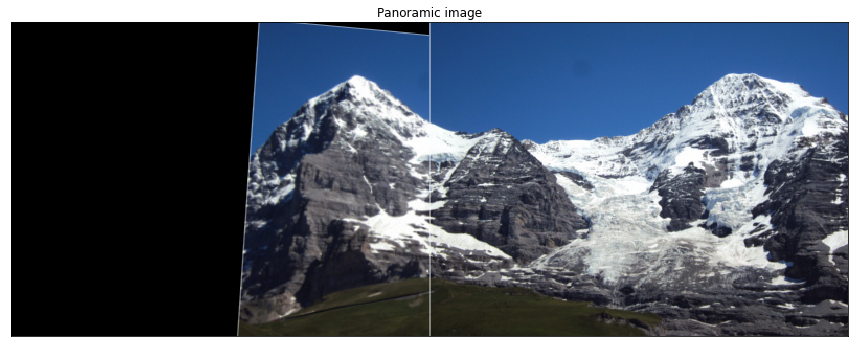

In [171]:
#3) Find homography using RANSAC method and apply transformation to 1Hill. Image 2Hill should not be transformed.

# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

mp_hill2 = np.float32([keypoints_hill1[i].pt for (__, i) in GoodMatches])
mp_hill1 = np.float32([keypoints_hill2[i].pt for (i, __) in GoodMatches])

for points in mp_hill1:
    points[0] += hill1.shape[1]

# find homography and warp image accordingly
H, __ = cv2.findHomography(mp_hill2, mp_hill1, cv2.RANSAC, 4)

wimg = cv2.warpPerspective(hill1, H, (hill1.shape[1]+hill2.shape[1],hill1.shape[0]))
wimg[:,-hill2.shape[1]:,:] = hill2

plt.figure(figsize=(15,15))
plt.imshow(wimg), plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

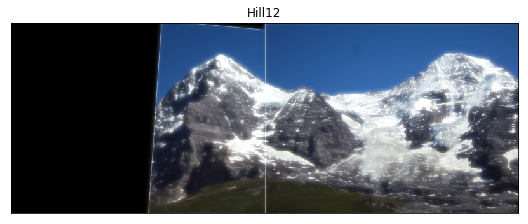

In [172]:
#4) Stitch transformed 1Hill and original 2Hill together using pyramid image blending.

hill12 = pyramidBlending(wimg[:,:hill1.shape[1]], hill2, 3)

# display results
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(hill12), plt.title('Hill12'), plt.xticks([]), plt.yticks([])
plt.show()


In [173]:
#1) Compute SURF keypoints and corresponding descriptors for images 12Hill and 3Hill.

hill12_grey = cv2.cvtColor(hill12, cv2.COLOR_BGR2GRAY)
hill3_grey = cv2.cvtColor(hill3, cv2.COLOR_BGR2GRAY)

# create SURF object
surf = cv2.xfeatures2d.SURF_create()

# detect SURF features
keypoints_hill12, descriptors_hill12 = surf.detectAndCompute(hill12_grey, None)
keypoints_hill3, descriptors_hill3 = surf.detectAndCompute(hill3_grey, None)

# number of SURF keypoints
print("Num keypoints: " + str(len(keypoints_hill12)))

Num keypoints: 1181


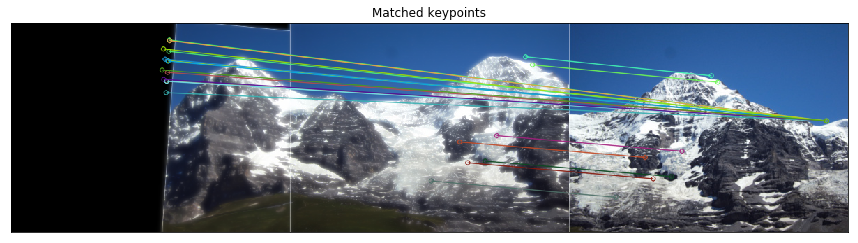

In [174]:
#2) Find matching keypoints in two images and display the 20 best pairs.

# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(descriptors_hill12,descriptors_hill3)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

hill3 = cv2.cvtColor(hill3, cv2.COLOR_BGR2RGB)

# Draw first 20 matches.
matched_disp = cv2.drawMatches(hill12, keypoints_hill12, hill3, keypoints_hill3, matches[:20],None, flags=2)


#display matchings
plt.figure(figsize=(15,15))
plt.imshow(matched_disp), plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

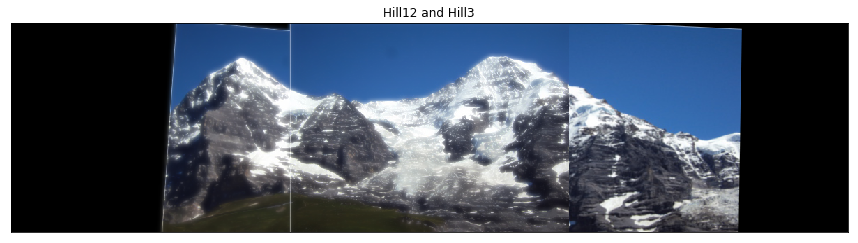

In [175]:
#3) Find homography using RANSAC method and apply transformation to 3Hill. Image 12Hill should not be transformed.

# Match descriptors.
matches = bf.match(descriptors_hill3, descriptors_hill12)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

good_matches = []
for _, m in enumerate(matches):
    good_matches.append((m.trainIdx, m.queryIdx))

# GoodMatches = GoodMatches[:-1]
mp_hill12 = np.float32([keypoints_hill12[i].pt for (i, __) in good_matches])
mp_hill3 = np.float32([keypoints_hill3[i].pt for (__, i) in good_matches])

# We shift all the points in the right image over as they are on smaller canvas
for i in range(len(mp_hill3)):
    mp_hill3[i][0] += hill12.shape[1] + hill3.shape[1]

H, _ = cv2.findHomography(mp_hill12, mp_hill3, cv2.RANSAC, 10)

# Use homography
wimg = cv2.warpPerspective(hill3, H, (hill1.shape[1]+hill2.shape[1]+hill3.shape[1], hill2.shape[0]))

wimg[:, :hill12.shape[1],:] = hill12
plt.figure(figsize=(15,15))
plt.imshow(glued)
plt.title("Hill12 and Hill3"),plt.xticks([]), plt.yticks([])
plt.show()

In [176]:
#4) Stitch transformed 3Hill and original 12Hill together using linear image blending.

**REASONING QUESTIONS**

_1. What are the differences betweeen SIFT and SURF? Comment on the speed, number of keypoints and density. Support your argument with statistics._

SURF is a faster version of the SIFT. SURF is usally up to 6 times faster than the SIFT method for locating keypoints as it uses box filters of any size to approximate the intergral operations. On the other hand, SIFT uses Gaussian sub sampling layers to smooth the image. The SURF method uses the Fast-Hessian matrix to determine the keypoint locations, making it less robust to changes when compared to SIFT. Hence the density of keypoints is smaller in the SURF method. Indeed, Hill1 and Hill2 have a total of 2726 SIFT keypoints, and Hill12 has 1181 SURF keypoints.

_2. Discuss at least two pros and cons of pyramid and linear blending techniques. When should one prefer pyramyid blending over linear blending?_

###### Pyramid blending pros
Allows the images to blend at different frequency levels. Removes ghosting from images more efficiently


###### Pyramd blending cons
Computationally heavy

###### Linear blending pros
Easy to implement

###### Linear blending cons
Des not work with all frequencies. Hard to balance between sharp transition retention and low frequency exposure variations.


_3. What would happen if a random subset of pairs of matching keypoints is used for finding homography?_

If a random subset of keypoints is used, the homography matrix may not be as accurate as using the best matching keypoints as the worst keypoints from two images does not reflect the same points.

_4. Discuss the relationship between the number of pairs of matching keypoints used for finding homography and the accuracy of inferred homography._

A higher amount of pairs of matching keypoints is not proportional to the accuracy of the inferred homography as good homography matrix only depends on the number of quality pairs of matching keypoints. Hence, if a lot of keypoints are used but all of them are on the low quality end of the spectrum, the inferred homography matrix will yield poor results when applied to an image. 